In [2]:
# Imports
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [3]:
# File Lists

base_path = 'C:/Users/ryans/Downloads/blood-vessel-segmentation/train/'
dataset = 'kidney_1_dense/'

images_path = os.path.join(base_path, dataset, 'images/')
labels_path = os.path.join(base_path, dataset, 'labels/')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

In [11]:
im_test = cv2.imread(label_files[512])

In [4]:
# Preprocessing

def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[..., None], [1, 1, 3])
    img = img.astype('float32')
    mx = np.max(img)
    if mx:
        img/=mx
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    return img_ten

def preprocess_mask(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)

    return msk_ten

In [5]:
# Augmentations
def augment_image(image, mask):

    image_np = image.permute(1,2,0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256,always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2,0,1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

In [6]:
# Create Dataset
class CustomDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)

        if self.augmentation_transforms:
            image, mask = self.augmentation_transforms(image, mask)

        return image, mask

In [1]:
# Train Test Split
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [8]:
# Create Train/Test Datasets
train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=None)
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=None)

In [9]:
# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

C:\Users\ryans\AppData\Roaming\Python\Python311\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])


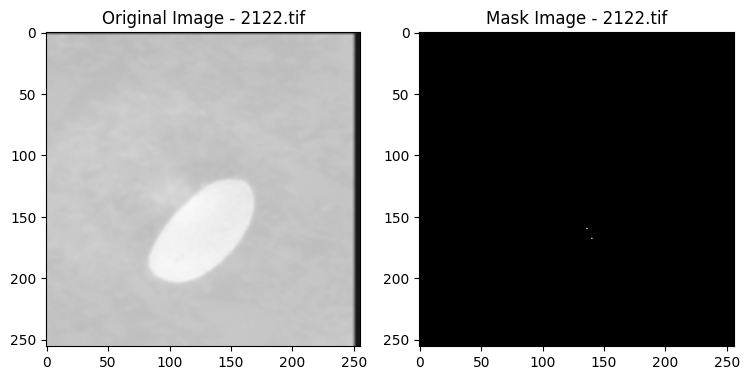

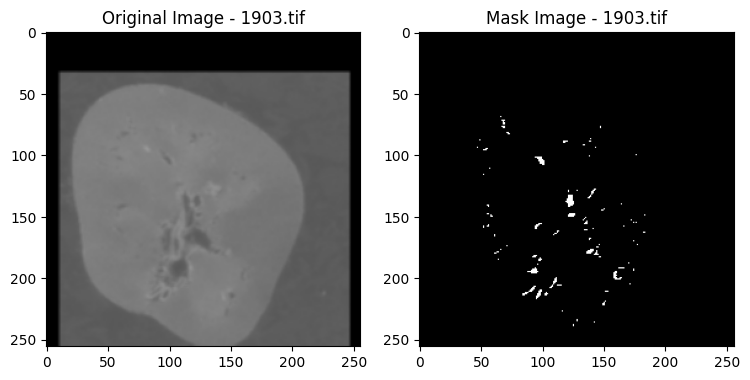

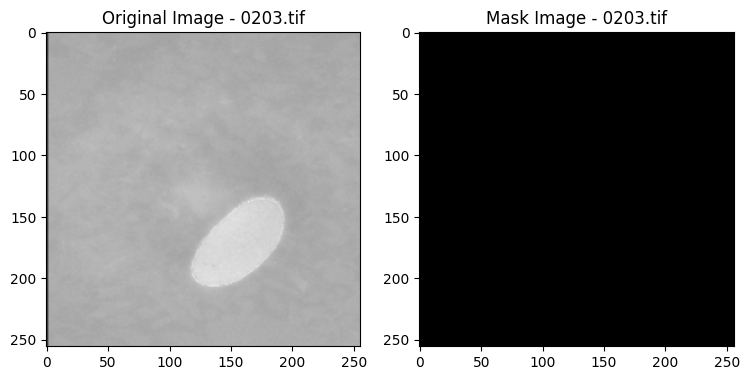

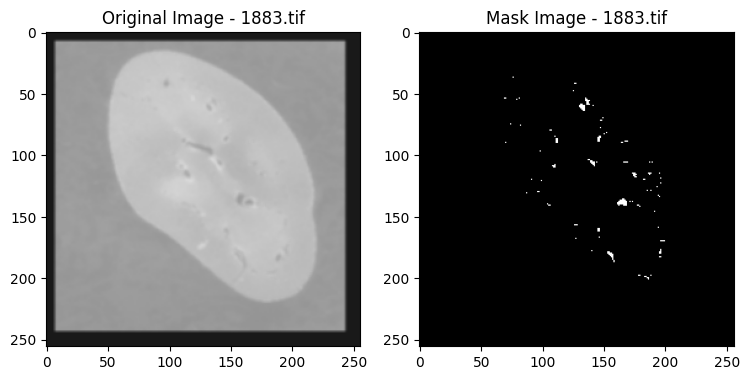

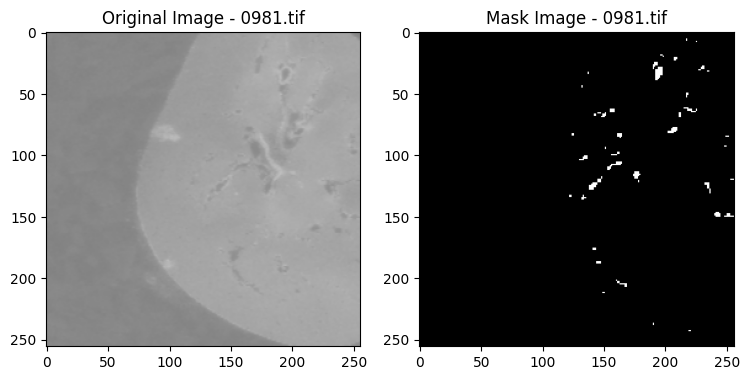

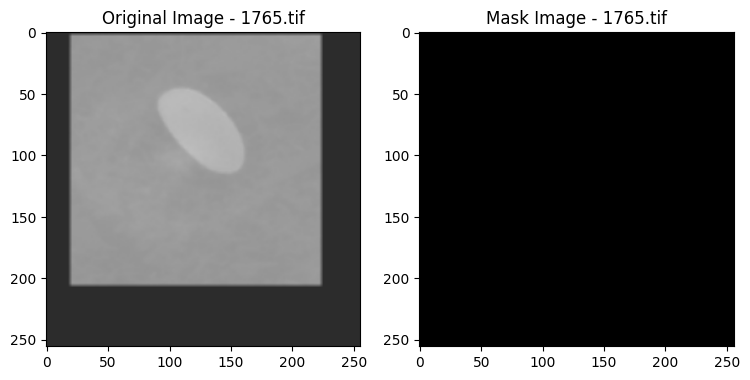

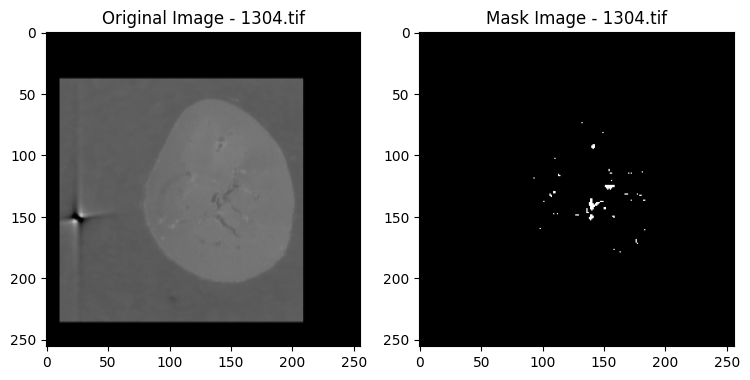

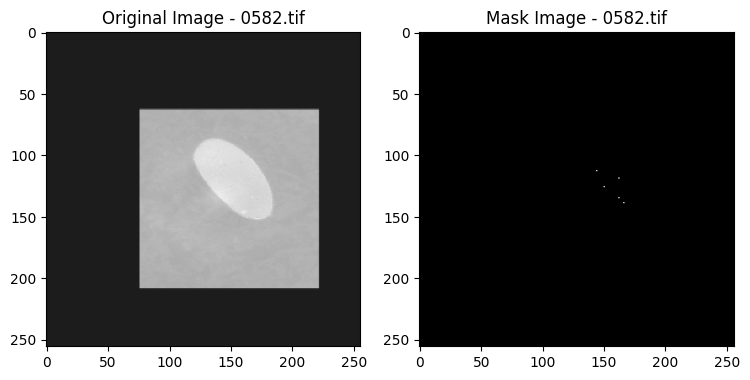

In [10]:
# Visualize Batches
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, train_image_files, train_mask_files):
        image = image.permute(1,2,0).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        plt.figure(figsize=(15,10))

        plt.subplot(2,4,1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image - {image_filename}")

        plt.subplot(2,4,2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Image - {mask_filename}")

        plt.tight_layout()
        plt.show()
    break

In [23]:
# Print Batch Shapes
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

C:\Users\ryans\AppData\Roaming\Python\Python311\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 2
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 3
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 4
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 5
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 6
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 7
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 8
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 9
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 10
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])

KeyboardInterrupt: 

In [11]:
# change pytorch to use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [12]:
# Define UNet
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [13]:
# Define DICE Coefficient
def dice_coeff(prediction, target):
    
    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

In [14]:
# Focal Loss
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, gamma=0, size_average=None, ignore_index=-100, reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = -F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [15]:
# Set Dataloader
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

In [22]:
# Train and Test Loop
def train_and_test(model, dataloaders, optimizer, criterion, num_epochs=100, show_images=False):
    since = time.time()
    best_loss = 1e10

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_dice_coeff', 'test_dice_coeff']
    train_epoch_losses = []
    test_epoch_losses = []
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        batchsummary = {a: [0] for a in fieldnames}
        batch_train_loss = 0.0
        batch_test_loss = 0.0

        for phase in ['training', 'test']:
            if phase == 'training':
                model.train()
            else:
                model.eval()

            for sample in iter(dataloaders[phase]):
                if show_images:
                    grid_img = make_grid(sample[0])
                    grid_img = grid_img.permute(1,2,0)
                    plt.imshow(grid_img)
                    plt.show()

                inputs = sample[0].to(device)
                masks = sample[1].to(device)

                masks = masks.unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)

                    y_ped = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()

                    batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_ped, y_true))
                    
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()
                        
                        batch_train_loss += loss.item() * sample[0].size(0)
                        
                    else:
                        batch_test_loss += loss.item() * sample[0].size(0)
                        
                if phase == 'training':
                    epoch_train_loss = batch_train_loss / len(dataloaders['training'])
                    train_epoch_losses.append(epoch_train_loss)
                else: 
                    epoch_test_loss = batch_test_loss / len(dataloaders['test'])
                    test_epoch_losses.append(epoch_test_loss)

                batchsummary['epoch'] = epoch

                print('{} Loss: {:.4f}'.format(phase, loss))

            best_loss = np.max(batchsummary['test_dice_coeff'])
            for field in fieldnames[3:]:
                batchsummary[field] = np.mean(batchsummary[field])
            print(
                f'\t\t\t train_dice_coeff: {batchsummary["training_dice_coeff"]}, test_dice_coeff: {batchsummary["test_dice_coeff"]}')

            print('Best dice coefficient: {:4f}'.format(best_loss))

            return model, train_epoch_losses, test_epoch_losses  

In [23]:
epochs = 25

def train():
    model = AttentionUNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = FocalLoss(gamma=2)

    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs)

    return trained_model, train_epoch_losses, test_epoch_losses

trained_model, train_epoch_losses, test_epoch_losses = train()

Epoch 1/25
----------
training Loss: 0.2060
training Loss: 0.1654
training Loss: 0.1425
training Loss: 0.1203
training Loss: 0.1091
training Loss: 0.0941
training Loss: 0.0881
training Loss: 0.0822
training Loss: 0.0745
training Loss: 0.0659
training Loss: 0.0601
training Loss: 0.0577
training Loss: 0.0553
training Loss: 0.0506
training Loss: 0.0468
training Loss: 0.0479
training Loss: 0.0471
training Loss: 0.0487
training Loss: 0.0394
training Loss: 0.0438
training Loss: 0.0377
training Loss: 0.0404
training Loss: 0.0370
training Loss: 0.0379
training Loss: 0.0348
training Loss: 0.0366
training Loss: 0.0332
training Loss: 0.0355
training Loss: 0.0318
training Loss: 0.0327
training Loss: 0.0342
training Loss: 0.0348
training Loss: 0.0439
training Loss: 0.0343
training Loss: 0.0383
training Loss: 0.0329
training Loss: 0.0339
training Loss: 0.0363
training Loss: 0.0305
training Loss: 0.0309
training Loss: 0.0320
training Loss: 0.0320
training Loss: 0.0293
training Loss: 0.0287
training L